# HOMEWORK 3#
## Valerio Zingarelli s281586 ##

In the following, I will explain and explore the methods I adopted to solve proposed exercises and the results I got.

In [186]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import scipy as sp
n_agents=500
k_in=4
G=nx.Graph()
G.add_nodes_from(list(range(n_agents)))
for n in range(n_agents):
    for i in range(int(k_in/2)):
        if n+i+1>=n_agents:
            G.add_edge(n,n+i+1-n_agents)
        else:
            G.add_edge(n,n+i+1)
        
pos = nx.circular_layout(G)
#If needed, un-comment the following two lines to draw the graph and save the obtained figure
#nx.draw(G,pos,with_labels=True)
#plt.savefig("graph1_1.pdf")

### Problem 1###
In order to semplify the other requests, I decided to define a function that includes the request of all the tasks needing to simulate an epidemic with SIR model. Parameters of the function are $\beta$, $\rho$, the number of iterations to computer the average, the number of initial infected and the number of agents(nodes) of the Graph. In addition to that, in case of vaccination, an apposite flag has been introduced and the $V(t)$ vector representing the percentage of people vaccinated during each week has been inserted too. The function, according to the value of an apposite flag "to_print", prints the obtained results or returns the arrays in order to store them.

In [2]:
#I define a function to use in next points
def SIRFunction(beta=0.3,rho=0.7,n_steps=15,n_iter=100,initial_infected=10,G=nx.Graph(),n_agents=500,vaccination=False,vaccine=[0,5,15,25,35,45,55,60,60,60,60,60,60,60,60],to_print=False):
    
    if not vaccination:
        new_infected=np.zeros(n_steps+1)
        new_infected[0]=initial_infected
        susceptible=np.zeros(n_steps+1)
        susceptible[0]=n_agents-initial_infected
        infected=np.zeros(n_steps+1)
        infected[0]=initial_infected
        recovered=np.zeros(n_steps+1)
        for iteration in range(n_iter):
            x = np.zeros((n_steps+1,n_agents))
            x0 = np.zeros(n_agents)
            # I set the initial condition:
            for i in range(initial_infected):
                random=np.random.randint(0,n_agents)
                if x0[random] != 1:
                    x0[random]=1
                else:
                    i=i-1
            x[0] = x0
            for week in range(1,n_steps+1):
                #the actual configuration is firstly equal to the previous one
                x[week]=x[week-1]
                for agent in G.nodes:
                    #if an agent is susceptible I compute the probability of infection and I infect it if it's the case
                    if x[week-1][agent] == 0:
                        neighbors=G.neighbors(agent)
                        infected_neighbors=0
                        for neighbor in neighbors:
                            if x[week-1][neighbor]==1:
                                infected_neighbors+=1
                        infection_probability= 1-(1-beta)**infected_neighbors
                        if infection_probability > np.random.rand():
                            x[week][agent]=1
                            new_infected[week]+=1
                        else:
                        #if the node doesn't get infected, then it's still susceptible
                            susceptible[week]+=1
                    #Recovery check
                    if x[week-1][agent] == 1:
                        if rho >= np.random.rand():
                            x[week][agent]=-1
                    if x[week][agent] == 1:
                        infected[week]+=1
                    if x[week][agent] == -1:
                        recovered[week]+=1
        new_infected[1:]=new_infected[1:]/n_iter   
        susceptible[1:]=susceptible[1:]/n_iter   
        infected[1:]=infected[1:]/n_iter   
        recovered[1:]=recovered[1:]/n_iter
        
        if to_print:
            print("Average new infected per week :",new_infected)
            print("Average Susceptible agents: ",susceptible)
            print("Average Infected agents: ",infected)
            print("Average Recovered agents: ",recovered)
        else:
            return new_infected,susceptible,infected,recovered
    else:
        vaccinated= np.zeros(n_steps+1)
        vaccinated[0]=int(vaccine[0]*n_agents/100)
        new_infected=np.zeros(n_steps+1)
        new_infected[0]=initial_infected
        susceptible=np.zeros(n_steps+1)
        susceptible[0]= n_agents-initial_infected
        infected=np.zeros(n_steps+1)
        infected[0]=initial_infected
        recovered=np.zeros(n_steps+1)
        recovered_because_of_vaccine=np.zeros(n_steps+1)
        number_of_vaccinations_each_week= np.asarray(vaccine)*n_agents/100
        number_of_vaccinations_each_week=number_of_vaccinations_each_week.astype(int)
        new_vaccinated_people_cum=np.zeros(n_steps+1)
        for iteration in range(n_iter):
            new_vaccinated_people=np.zeros(n_steps)
            x = np.zeros((n_steps+1,n_agents))
            x0 = np.zeros(n_agents)
            # I set the initial condition:
            for i in range(initial_infected):
                random=np.random.randint(0,n_agents)
                if x0[random] != 1:
                    x0[random]=1
                else:
                    i=i-1
            
            x[0] = x0
            for week in range(1,n_steps+1):
                #the actual configuration is firstly equal to the previous one
                x[week]=x[week-1]
                #I find people to vaccinate (if an agent is equal to 2, it means it is vaccinated):
                possible_vaccinations= [agent for agent in G.nodes if x[week][agent]!=2]
                if week==1:
                    new_vaccinations=number_of_vaccinations_each_week[0]
                else:
                    new_vaccinations= number_of_vaccinations_each_week[week-1]-number_of_vaccinations_each_week[week-2]
                to_vaccinate= np.random.choice(possible_vaccinations,size=int(new_vaccinations), replace=False)
                x[week][to_vaccinate]=2
                new_vaccinated_people[week-1] += new_vaccinations
                new_vaccinated_people_cum[week-1] += new_vaccinations
                for agent in G.nodes:
                    if x[week-1][agent] == 0 and x[week][agent]!=2:
                        neighbors=G.neighbors(agent)
                        infected_neighbors=0
                        for neighbor in neighbors:
                            if x[week-1][neighbor]==1:
                                infected_neighbors+=1
                        infection_probability= 1-(1-beta)**infected_neighbors
                        if infection_probability > np.random.rand():
                            x[week][agent]=1
                            new_infected[week]+=1
                        else:
                        #if the node doesn't get infected, then it's still susceptible
                            susceptible[week]+=1
                    if x[week-1][agent] == 1 and x[week][agent]!=2: 
                        if rho >= np.random.rand():
                            x[week][agent]=-1
                    #Stats computation 
                    if x[week][agent]== 1:
                        infected[week]+=1
                    if x[week][agent] == -1:
                        recovered[week]+=1
                    if x[week][agent] == 2:
                        vaccinated[week]+=1
                    if x[week][agent] == 2 and x[week-1][agent] == 1:
                        #I compute the number of people recovered because of vaccination
                        recovered_because_of_vaccine[week]+=1
            
        new_infected[1:]=new_infected[1:]/n_iter   
        susceptible[1:]=susceptible[1:]/n_iter   
        infected[1:]=infected[1:]/n_iter   
        recovered[1:]=recovered[1:]/n_iter  
        vaccinated[1:]=vaccinated[1:]/n_iter
        new_vaccinated_people_average=new_vaccinated_people_cum/n_iter
        recovered_because_of_vaccine=recovered_because_of_vaccine/n_iter
        if to_print:
            print("Average new infected agents per week :",new_infected)
            print("Average new vaccinated agents per week :",new_vaccinated_people_average)
            print("Average Susceptible agents per week: ",susceptible)
            print("Average Infected agents per week: ",infected)
            print("Average Recovered agents per week: ",recovered)
            print("Average Vaccinated agents per week: ",vaccinated)
            print("Average Recovered because of vaccine agents per week:",recovered_because_of_vaccine)
        else:
            return new_infected,new_vaccinated_people_average,susceptible,infected,recovered,vaccinated,recovered_because_of_vaccine

Applying the same reasoning made before, I decided to define a function for creating a Random Graph following Preferential Attachment approach. In addition to this, in the following cell, other methods to create Random Graphs have been implemented.

In [3]:
#EX 1.2 Random Graph
def PreferentialAttachment(k=10,n_nodes=900,G1=nx.Graph(),to_print=False):
    G1=nx.complete_graph(k+1)
    odd=False
    if k%2!=0:
        odd=True

    # add nodes one at a time
    for node in range(len(G1),n_nodes):

        G1_degs = [d for n,d in G1.degree()] 
        G1_degs = np.array(G1_degs)
        # normalize to obtain a probability distribution
        G1_degs = G1_degs/sum(G1_degs)
        # replace=False guarantees no neighbor is chosen twice
        if odd and node%2!=0:
            neighbors = np.random.choice(a=np.arange(len(G1)), p=G1_degs, size=int(k/2)+1, replace=False)
        else:
            neighbors = np.random.choice(a=np.arange(len(G1)), p=G1_degs, size=int(k/2), replace=False)
        # add the new node (new node is added even if its out-degree is zero)
        G1.add_node(node)
        # add the new links 
        for neigh in neighbors:
            G1.add_edge(node,neigh) 
    degree_sum=0
    for n,d in G1.degree():
        degree_sum+=d
    average_degree=degree_sum/G1.number_of_nodes()
    if to_print==True:
        print("Average degree: ", average_degree)
    return G1


In [92]:
#Other algorithms to generate random graphs
def SmallWorld(n_nodes=500,k=10,to_print=True,p=0.05):
    #minimum probability to have ExpectedValue(L)>=1
    p_min=2/(n_nodes*k)
    if p<p_min:
        print("Error: p must b at least ",p_min)
        return None
    G=nx.Graph()
    G.add_nodes_from(list(range(n_nodes)))
    for n in range(n_nodes):
        for i in range(int(k/2)):
            if n+i+1>=n_nodes:
                G.add_edge(n,n+i+1-n_nodes)
            else:
                G.add_edge(n,n+i+1)
    for n in range(n_nodes):
        G.add_edge(n,((n+2) % n_nodes))
        G.add_edge(n,((n-2) % n_nodes))
        
        
    I=np.random.binomial(n=(n*k/2),p=p)
    possible_links= []
    for i in range(len(G.nodes)):
        for j in range(len(G.nodes)):
            if (i,j) not in G.edges and i!=j:
                possible_links.append((i,j))
    idx=np.random.choice(a=len(possible_links),size=I,replace=False)
    for link in np.asarray(possible_links)[idx]:
        G.add_edge(link[0],link[1])
        
        
        
    average_degree=sum([d for n,d in G.degree()])/G.number_of_nodes()
    if to_print==True:
        print("Average degree: ", average_degree)
        print("Diameter:", nx.diameter(G))
        print("Clustering coefficient", nx.average_clustering(G), "\n")
        pos = nx.circular_layout(G)
        nx.draw(G,with_labels=True,pos=pos)
    return G

## EX 1.1##
I use the functions implemented before to simulate the epidemics using provided parameters. In different cells, code needed for plotting graphs has been provided.

In [5]:
#EX 1.1
SIRFunction(beta=0.3,G=G,rho=0.7,n_steps=15,n_iter=100,initial_infected=10,n_agents=500,to_print=True)

Average new infected per week : [10.   11.96 10.91  8.21  6.1   4.59  3.21  2.5   1.78  1.14  0.86  0.48
  0.45  0.22  0.16  0.09]
Average Susceptible agents:  [490.   478.12 467.21 459.   452.9  448.31 445.1  442.6  440.82 439.68
 438.82 438.34 437.89 437.67 437.51 437.42]
Average Infected agents:  [10.   14.94 15.33 13.06 10.31  7.67  5.58  4.21  2.85  1.95  1.35  0.89
  0.73  0.4   0.29  0.13]
Average Recovered agents:  [ 0.    6.94 17.46 27.94 36.79 44.02 49.32 53.19 56.33 58.37 59.83 60.77
 61.38 61.93 62.2  62.45]


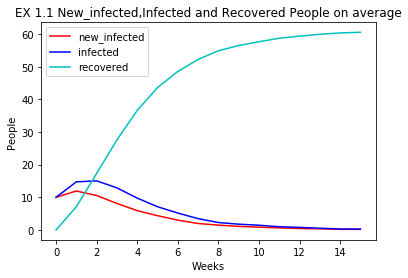

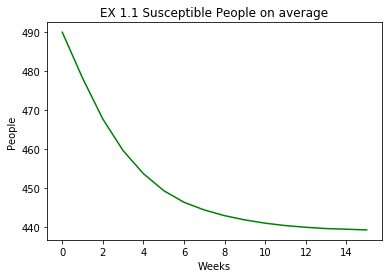

In [6]:
#EX 1.1 plots
new_infected,susceptible,infected,recovered=SIRFunction(beta=0.3,G=G,rho=0.7,n_steps=15,n_iter=100,initial_infected=10,n_agents=500)
plt.figure()
x=range(16)
# Plotting all the curves simultaneously
plt.plot(x, new_infected, color='r',label="new_infected")
plt.plot(x, infected, color='b',label="infected")
plt.plot(x, recovered, color='c',label="recovered")

  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Weeks")
plt.ylabel("People")
plt.title("EX 1.1 New_infected,Infected and Recovered People on average")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
plt.savefig("NI_I_R_EX1_1.pdf")
# To load the display window
plt.show()

plt.plot(x, susceptible, color='g',label="susceptible")
plt.xlabel("Weeks")
plt.ylabel("People")
plt.title("EX 1.1 Susceptible People on average")
plt.savefig("S_EX1_1.pdf")

## EX 1.2##
In the following cells it's possible to find the application of the function to generate random graphs with Preferential Attachment method. Notice that 2 different applications have been provided: the first one for $k=4$ which is even and the second one with $k=5$ which is odd. In both cases the obtained graph has desired average degree.

In [7]:
#EX 1.2
G_even=PreferentialAttachment(k=4,n_nodes=1000)
Average_even=sum([d for n,d in G_even.degree])/len(G_even)
print("Average degree if k=4 is even: ",Average_even)


Average degree if k=4 is even:  4.0


In [8]:
G_odd=PreferentialAttachment(k=5,n_nodes=1000)

Average_odd=sum([d for n,d in G_odd.degree])/len(G_odd)

print("Average degree if k=5 is odd: ",Average_odd)

Average degree if k=5 is odd:  5.0


## Problem 2##
The second problem is basically an application of the two
algorithms created during points 1.1 and 1.2. So firstly we
were required to create a random graph with $k = 6$ using the
algorithm developed during point 1.2 and then, to apply the
SIR epidemic’s model to the graph we had just created. 

In [9]:
#EX 2
G_problem2=PreferentialAttachment(k=6,n_nodes=500,to_print=True)
SIRFunction(beta=0.3,rho= 0.7,n_steps=15,n_iter=100,initial_infected=10,G=G_problem2,n_agents=500,to_print=True)

Average degree:  6.0
Average new infected per week : [1.0000e+01 1.6220e+01 5.7520e+01 1.0619e+02 1.0485e+02 6.1940e+01
 3.0550e+01 1.2350e+01 5.3100e+00 1.9800e+00 8.4000e-01 3.5000e-01
 1.5000e-01 8.0000e-02 3.0000e-02 0.0000e+00]
Average Susceptible agents:  [490.   473.83 416.31 310.12 205.27 143.33 112.78 100.43  95.12  93.14
  92.3   91.95  91.8   91.72  91.69  91.69]
Average Infected agents:  [1.0000e+01 1.9280e+01 6.3380e+01 1.2563e+02 1.4229e+02 1.0393e+02
 6.2240e+01 3.1230e+01 1.4630e+01 6.2800e+00 2.7200e+00 1.1900e+00
 4.9000e-01 2.0000e-01 1.1000e-01 4.0000e-02]
Average Recovered agents:  [  0.     6.89  20.31  64.25 152.44 252.74 324.98 368.34 390.25 400.58
 404.98 406.86 407.71 408.08 408.2  408.27]


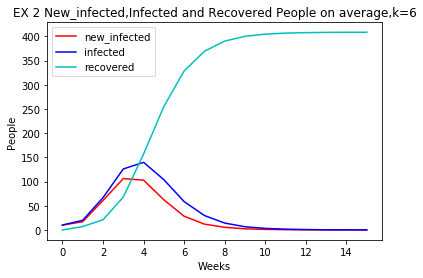

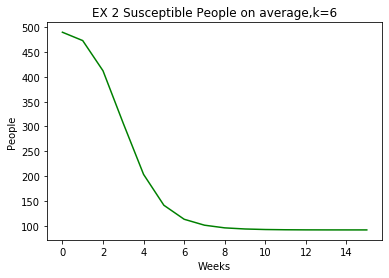

In [10]:
#EX2 plots
k_plot=6
new_infected,susceptible,infected,recovered=SIRFunction(beta=0.3,G=G_problem2,rho=0.7,n_steps=15,n_iter=100,initial_infected=10,n_agents=500)
plt.figure()
x=range(16)
# Plotting all the curves simultaneously
plt.plot(x, new_infected, color='r',label="new_infected")
plt.plot(x, infected, color='b',label="infected")
plt.plot(x, recovered, color='c',label="recovered")

  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Weeks")
plt.ylabel("People")
plt.title("EX 2 New_infected,Infected and Recovered People on average,k="+str(k_plot))

  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To save figure
plt.savefig("NI_I_R_EX2_k="+str(k_plot)+".pdf")
# To load the display window
plt.show()

plt.plot(x, susceptible, color='g',label="susceptible")
plt.xlabel("Weeks")
plt.ylabel("People")
plt.title("EX 2 Susceptible People on average,k="+str(k_plot))
plt.savefig("S_EX2_k="+str(k_plot)+".pdf")
plt.show()


## Problem 3 ##
In this exercise, we have to deal with vaccinations. In
fact, the request was to simulate a pandemic $with$ vaccination.
In fact, the request was to simulate a pandemic \textit{with vaccination} according to the previously developed SIR discrete model. In particular, we were given :
\begin{equation}
    V(t)= [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
    \label{Vaccine3}
\end{equation}
This array should be interpreted as: 55\% of the population has received vaccination by week 7, and 5\% received vaccination during week 7. 

In [11]:
#EX3
SIRFunction(beta=0.3,rho= 0.7,n_steps=15,n_iter=100,initial_infected=10,G=G_problem2,n_agents=500,vaccination=True,to_print=True)

Average new infected agents per week : [1.000e+01 1.611e+01 5.919e+01 8.890e+01 6.639e+01 3.012e+01 1.070e+01
 2.990e+00 6.800e-01 2.400e-01 3.000e-02 0.000e+00 0.000e+00 1.000e-02
 0.000e+00 0.000e+00]
Average new vaccinated agents per week : [ 0. 25. 50. 50. 50. 50. 50. 25.  0.  0.  0.  0.  0.  0.  0.  0.]
Average Susceptible agents per week:  [490.   473.97 390.96 260.71 163.97 112.32  84.78  66.79  58.71  58.47
  58.44  58.44  58.44  58.43  58.43  58.43]
Average Infected agents per week:  [1.0000e+01 1.9060e+01 6.4710e+01 1.0604e+02 9.3930e+01 5.4570e+01
 2.4900e+01 9.1700e+00 3.0000e+00 1.1900e+00 3.5000e-01 7.0000e-02
 2.0000e-02 1.0000e-02 0.0000e+00 0.0000e+00]
Average Recovered agents per week:  [  0.     6.97  19.33  58.25 117.1  158.11 165.32 149.04 138.29 140.34
 141.21 141.49 141.54 141.56 141.57 141.57]
Average Vaccinated agents per week:  [  0.   0.  25.  75. 125. 175. 225. 275. 300. 300. 300. 300. 300. 300.
 300. 300.]
Average Recovered because of vaccine agents per wee

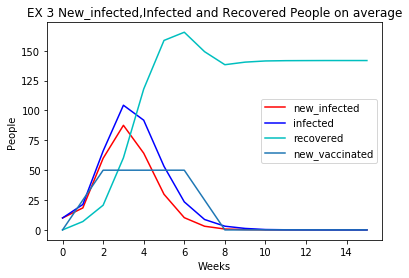

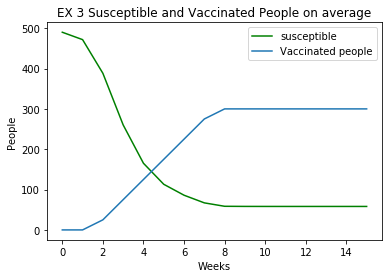

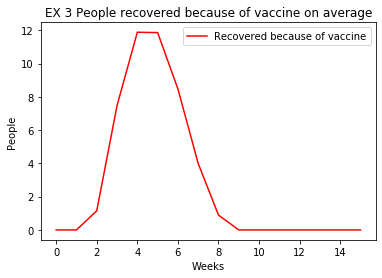

In [12]:
#EX3 plots
new_infected,new_vaccinated_people,susceptible,infected,recovered,vaccinated_cum,recovered_because_of_vaccine=SIRFunction(beta=0.3,G=G_problem2,rho=0.7,n_steps=15,n_iter=100,initial_infected=10,n_agents=500,vaccination=True)
plt.figure()
x=range(16)
# Plotting all the curves simultaneously
plt.plot(x, new_infected, color='r',label="new_infected")
plt.plot(x, infected, color='b',label="infected")
plt.plot(x, recovered, color='c',label="recovered")
plt.plot(x, new_vaccinated_people,label="new_vaccinated")
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Weeks")
plt.ylabel("People")
plt.title("EX 3 New_infected,Infected and Recovered People on average")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.savefig("NI_I_R_EX3.pdf")
plt.show()

plt.plot(x, susceptible, color='g',label="susceptible")
plt.plot(x,vaccinated_cum,label="Vaccinated people")
plt.xlabel("Weeks")
plt.ylabel("People")
plt.legend()
plt.title("EX 3 Susceptible and Vaccinated People on average")
plt.savefig("S_EX3.pdf")
plt.show()

plt.plot(x,recovered_because_of_vaccine,color="r",label="Recovered because of vaccine")
plt.xlabel("Weeks")
plt.ylabel("People")
plt.legend()
plt.title("EX 3 People recovered because of vaccine on average")
plt.savefig("RV_EX3.pdf")
plt.show()

## Problem 4 ##
In this exercise, we were required to find the best parameters $k$,$\beta$,$\rho$ to model a simplified version of the H1N1 epidemics occurred in Sweden in 2009. In this case, the number of nodes of the graph we have to deal with is $|\mathcal{V}|=934$. In order to prove the algorithm is doing right, the real evolution of newly infected people has been provided: 
<br>

\begin{equation}
    I_0=[1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
\end{equation}
<br>
During the weeks we were asked to simulate, vaccine has been received by people according to the following:


\begin{equation}
    V(t)=[5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
\end{equation}

Of course, this array should be read exactly like the previous one from Problem 3. 
In order to find the best parameters, provided algorithm has been followed. In particular starting from a random guess $k_0,\beta_0$ and $\rho_0$ and for each configuration in parameter spaces $k\in[k_0−\Delta k, k_0, k_0+\Delta k]$, $\beta\in[\beta_0−\Delta \beta, \beta_0, \beta_0+\Delta \beta]$, $\rho \in[\rho_0−\Delta \rho, \rho_0, \rho_0+\Delta \rho]$ : <br>
1) Create a random graph $\mathcal{G}$ with $|\mathcal{V}|=934$ and $degree=k$ <br>
2) Simulate the pandemic on $\mathcal{G}$ <br>
3)  Compute RMSE between obtained results and $I_0$ <br>
4)  Update $k_0$ $\rho_0$ $\beta_0$ with the best found parameters. <br>

In this way it's possible to detect the best configuration and explore its neighbourhood in order to find a better one.

In [214]:
#EX4
def RMSE(A,B):
    RMSE= np.sqrt(((A[1:]-B[1:])**2).sum()/(len(A)-1))
    return RMSE 
def AlgorithmEX4(k0=10,beta0=0.3,p0=0.6,delta_k=1,delta_beta=0.1,delta_p=0.1,I0=[1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0],algorithm="PreferentialAttachment"):
    beta=beta0
    p=p0
    k=k0
    beta_old=beta
    k_old=k
    p_old=p
    lowest=float("inf")
    new_best_params=(float("inf"),float("inf"),float("inf"))
    first=True
    visited_configurations=[]
    while (beta_old,p_old,k_old)!= new_best_params:
        if first==False:
            beta_old,p_old,k_old=new_best_params
        configs=[]
        betas=[beta_old,beta_old+delta_beta,beta_old-delta_beta]
        ks=[k_old,k_old+delta_k,k_old-delta_k]
        ps=[p_old,p_old+delta_p,p_old-delta_p]
        for beta in betas:
            for k in ks:
                for p in ps:
                    configs.append((beta,k,p))
        for config in configs:
            if config not in(visited_configurations):
                beta,k,p=config
                if k!=0:
                    if algorithm=="PreferentialAttachment":
                        G=PreferentialAttachment(k=k,n_nodes=934)
                    elif algorithm=="SmallWorld":
                        G=SmallWorld(k=k,n_nodes=934,p=0.40,to_print=False)
                    new_infected,new_vaccinated_people,susceptible,infected,recovered,vaccinated,recovered_because_of_vaccine=SIRFunction(beta=beta,rho=p,n_steps=15,n_iter=10,initial_infected=1,G=G,n_agents=934,vaccination=True,vaccine = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60],to_print=False)
                    RMSE_value=RMSE(new_infected,I0)
                    if RMSE_value<lowest:
                        new_best_params=(beta,p,k)
                        best_new_infected=new_infected
                        best_new_vaccinated=new_vaccinated_people
                        best_susceptible=susceptible
                        best_infected=infected
                        best_vaccinated=vaccinated_cum
                        best_recovered= recovered
                        lowest=RMSE_value
                visited_configurations.append(config)
                  
            #print (config, RMSE_value)
        
        #If a parameter is the same in 2 successive "best" steps, I divide it by half
        if (config[0]== new_best_params[0] and config[1]== new_best_params[1]):
            delta_beta=delta_beta/2
            delta_p=delta_p/2
        elif (config[1]== new_best_params[1]):
            delta_p=delta_p/2
        elif(config[0]== new_best_params[0]):
            delta_beta=delta_beta/2
            
        first=False
        
    return(new_best_params,best_new_infected,best_new_vaccinated,best_susceptible,best_infected,best_vaccinated,best_recovered,lowest)          

In [219]:
best_params,best_interpolation,_,_,_,_,_,best_RMSE=AlgorithmEX4(algorithm="PreferentialAttachment")
print(best_params,best_interpolation,best_RMSE)

(0.14999999999999997, 0.7999999999999999, 9) [ 1.   1.4  2.9  5.2 10.7 18.5 24.2 21.4 14.1  7.8  3.6  2.   1.1  0.4
  0.   0. ] 3.649018132776725


In [217]:
#This is to compute an average for best RMSE
best_RMSE_cum=0
n_average=10
for i in range(n_average):
    print(i)
    best_params,best_new_infected,best_new_vaccinated,best_susceptible,best_infected,best_vaccinated,best_recovered,best_RMSE=AlgorithmEX4(algorithm="SmallWorld")
    best_RMSE_cum+=best_RMSE
print("Average best value of RMSE obtained by the simulations: ",best_RMSE_cum/n_average)

0
1
2
3
4
5
6
7
8
9
Average best value of RMSE obtained by the simulations:  5.786789933408332


In [ ]:
# Plotting all the curves simultaneously
best_params,best_new_infected,best_new_vaccinated,best_susceptible,best_infected,best_vaccinated,best_recovered,best_RMSE=AlgorithmEX4()
plt.plot(x, best_interpolation, color='r',label="new_infected")
plt.plot(x, best_infected, color='b',label="infected")
plt.plot(x, best_recovered, color='c',label="recovered")
plt.plot(x, best_new_vaccinated,label="new_vaccinated")
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Weeks")
plt.ylabel("People")
plt.title("EX 4 New_infected,Infected and Recovered People on average")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.savefig("NI_I_R_EX4.pdf")
plt.show()

plt.plot(x, best_susceptible, color='g',label="susceptible")
plt.plot(x,best_vaccinated,label="Vaccinated people")
plt.xlabel("Weeks")
plt.ylabel("People")
plt.legend()
plt.title("EX 4 Susceptible and Vaccinated People on average")
plt.savefig("S_EX4.pdf")
plt.show()

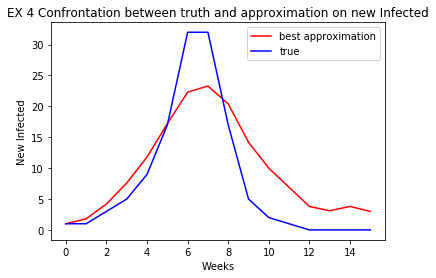

In [218]:
#EX 4 Comparison plots
x=range(16)
I0=[1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
# Plotting all the curves simultaneously
plt.plot(x, best_interpolation, color='r',label="best approximation")
plt.plot(x, I0, color='b',label="true")
plt.xlabel("Weeks")
plt.ylabel("New Infected")
plt.legend()
plt.title("EX 4 Confrontation between truth and approximation on new Infected")
plt.savefig("EX4.pdf")


## Problem 5 ##
The last task required to find a better way of both creating the random graph and find the best parameters to model Sweden's H1N1 epidemics' diffusion.
The idea behind the "new" algorithm is to explore all the space of probability for rho and Beta and, concerning k, the idea is to explore the interval $[0,2k]$. Indeed, if we are close to a local optimum, the algorithm proposed in the previous point just stops, for example: if we have a local optimum for $k=10$ but a global optimum for $k=13$, the solution with $k=13$ will never be explored because the algorithm developed in problem 4 stops before.

In [112]:
#EX5


def AlgorithmEX5(k0=10,beta0=0.3,p0=0.6,delta_k=1,delta_beta=0.1,delta_p=0.1,I0=[1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0],algorithm="PreferentialAttachment"):
    beta=beta0
    p=p0
    k=k0
    beta_old=beta
    k_old=k
    p_old=p
    lowest=float("inf")
    new_best_params=(float("inf"),float("inf"),float("inf"))
    first=True
    visited_configurations=[]
    #If I found the same configuration for 2 successive iterations it means I need to stop
    while (beta_old,p_old,k_old)!= new_best_params:
        if first==False:
            beta_old,p_old,k_old=new_best_params
        configs=[]
        betas=np.arange(0.1,1,delta_beta)
        ks=np.arange(1,2*k_old,1)
        ps=np.arange(0.1,1,delta_p)
        #I generate all the possible configurations
        for beta in betas:
            for k in ks:
                for p in ps:
                    configs.append((beta,k,p))
        for config in configs:
            if config not in(visited_configurations):
                beta,k,p=config
                if k!=0:
                    # I generate the graph with Preferential Attachment or SmallWorld and I
                    #simulate the epidemics on it. If I manage to get a better RMSE value, I save the
                    # model that generated it.
                    if algorithm=="PreferentialAttachment":
                        G=PreferentialAttachment(k=k,n_nodes=934)
                    elif algorithm=="SmallWorld":
                        G=SmallWorld(k=k,n_nodes=934,p=0.40,to_print=False)
                    else:
                        print("ERROR: algorithm is not valid")
                    new_infected,new_vaccinated_people,susceptible,infected,recovered,vaccinated,recovered_because_of_vaccine=SIRFunction(beta=beta,rho=p,n_steps=15,n_iter=10,initial_infected=1,G=G,n_agents=934,vaccination=True,vaccine = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60],to_print=False)
                    RMSE_value=RMSE(new_infected,I0)
                    if RMSE_value<lowest:
                        new_best_params=(beta,p,k)
                        best_new_infected=new_infected
                        best_new_vaccinated=new_vaccinated_people
                        best_susceptible=susceptible
                        best_infected=infected
                        best_vaccinated=vaccinated_cum
                        best_recovered= recovered
                        lowest=RMSE_value
                visited_configurations.append(config)
        
        #If a parameter is the same in 2 successive "best" steps, I divide it by half
        if (config[0]== new_best_params[0] and config[1]== new_best_params[1]):
            delta_beta=delta_beta/2
            delta_p=delta_p/2
        elif (config[1]== new_best_params[1]):
            delta_p=delta_p/2
        elif(config[0]== new_best_params[0]):
            delta_beta=delta_beta/2
            
        first=False
        
    return(new_best_params,best_new_infected,best_new_vaccinated,best_susceptible,best_infected,best_vaccinated,best_recovered,lowest)          

In [220]:
best_params,best_interpolation,_,_,_,_,_,best_RMSE=AlgorithmEX5()
print(best_params,best_interpolation,best_RMSE)

(0.1, 0.6, 14) [ 1.   1.4  4.4  8.7 14.3 24.8 32.  28.  17.3 11.8  6.4  4.8  3.2  2.5
  2.7  2.2] 3.9114362238611706


In [ ]:
#EX 5 plots
x=range(16)
I0=[1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
# Plotting all the curves simultaneously
plt.plot(x, best_interpolation, color='r',label="best approximation")
plt.plot(x, I0, color='b',label="true")
plt.xlabel("Weeks")
plt.ylabel("New Infected")
plt.legend()
plt.title("EX 5 Confrontation between truth and approximation")
plt.savefig("EX5.pdf")

## Changing in initial infected generation ##
In the following, I will try to change the way initial infected people get generated in order to obtain a more realistic evolution since it's quite improbable that 10(or more) people get infected in different part of a country simultaneously. Indeed, if I get infected by a virus and I am the first one( patient zero), I will pass the infection to people that I meet everyday and not to a guy which I don't know and lives in a completely different part of the country. So a good idea to improve the creation of initially infected people could be the infection of one agent(patient zero) and his/her $n$ neighbours. This could lead to a more realistic evolution of the epidemics if the patient zero is in the country we are working on, otherwise the choice adopted in previous problems is a valid choice.

In [209]:
# I try to change the initial creation of infected
def SIRFunctionInitialInfectedChange(beta=0.3,rho=0.7,n_steps=15,n_iter=100,initial_infected=10,G=nx.Graph(),n_agents=500,to_print=False):
        new_infected=np.zeros(n_steps+1)
        new_infected[0]=initial_infected
        susceptible=np.zeros(n_steps+1)
        susceptible[0]=n_agents-new_infected[0]
        infected=np.zeros(n_steps+1)
        infected[0]=initial_infected
        recovered=np.zeros(n_steps+1)
        for iteration in range(n_iter):
            x = np.zeros((n_steps+1,n_agents))
            x0 = np.zeros(n_agents)
            # I set the initial condition:
            infected_initially=0
            zero_patient=np.random.choice(a=x0,size=1,replace=False)
            #I take the friends of patient zero and the friends of friends of patient zero
            start_infected_nodes=[int(zero_patient)]
            possible_infections=[]
            while infected_initially< initial_infected:
                for agent in start_infected_nodes:
                    for neigh in G.neighbors(agent):
                        if neigh not in possible_infections:
                            possible_infections.append(neigh)
                    random= np.random.choice(a=possible_infections,replace=False)
                    if x0[random] !=1 :
                        x0[random]=1
                        if random not in start_infected_nodes:
                            start_infected_nodes.append(random)
                        infected_initially+=1
            x[0] = x0
            for week in range(1,n_steps+1):
                #the actual configuration is firstly equal to the previous one
                x[week]=x[week-1]
                for agent in G.nodes:
                    #if an agent is susceptible I compute the probability of infection and I infect it if it's the case
                    if x[week-1][agent] == 0:
                        neighbors=G.neighbors(agent)
                        infected_neighbors=0
                        for neighbor in neighbors:
                            if x[week-1][neighbor]==1:
                                infected_neighbors+=1
                        infection_probability= 1-(1-beta)**infected_neighbors
                        if infection_probability > np.random.rand():
                            x[week][agent]=1
                            new_infected[week]+=1
                        else:
                        #if the node doesn't get infected, then it's still susceptible
                            susceptible[week]+=1
                    #Recovery check
                    if x[week-1][agent] == 1:
                        if rho >= np.random.rand():
                            x[week][agent]=-1
                    if x[week][agent] == 1:
                        infected[week]+=1
                    if x[week][agent] == -1:
                        recovered[week]+=1
        new_infected[1:]=new_infected[1:]/n_iter   
        susceptible[1:]=susceptible[1:]/n_iter   
        infected[1:]=infected[1:]/n_iter   
        recovered[1:]=recovered[1:]/n_iter
        
        if to_print:
            print("Average new infected per week :",new_infected)
            print("Average Susceptible agents: ",susceptible)
            print("Average Infected agents: ",infected)
            print("Average Recovered agents: ",recovered)
        else:
            return new_infected,susceptible,infected,recovered


In [211]:
SIRFunctionInitialInfectedChange(G=G,to_print=True)

Average new infected per week : [10.    2.27  1.31  0.89  0.89  0.67  0.53  0.31  0.25  0.17  0.17  0.09
  0.05  0.01  0.01  0.  ]
Average Susceptible agents:  [490.   485.79 484.48 483.59 482.7  482.03 481.5  481.19 480.94 480.77
 480.6  480.51 480.46 480.45 480.44 480.44]
Average Infected agents:  [10.    6.06  2.98  1.75  1.5   1.14  0.88  0.57  0.44  0.31  0.27  0.19
  0.14  0.06  0.02  0.01]
Average Recovered agents:  [ 0.    8.15 12.54 14.66 15.8  16.83 17.62 18.24 18.62 18.92 19.13 19.3
 19.4  19.49 19.54 19.55]


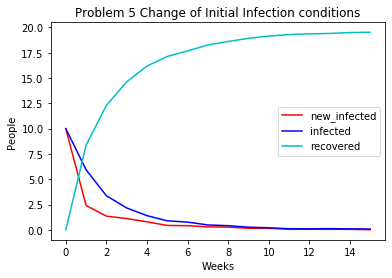

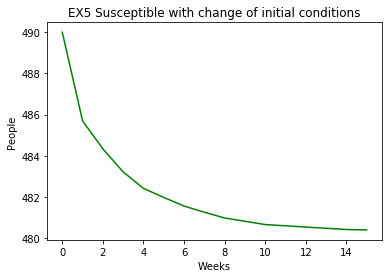

In [212]:
new_infected,susceptible,infected,recovered=SIRFunctionInitialInfectedChange(beta=0.3,G=G,rho=0.7,n_steps=15,n_iter=100,n_agents=500)
plt.figure()
x=range(16)
# Plotting all the curves simultaneously
plt.plot(x, new_infected, color='r',label="new_infected")
plt.plot(x, infected, color='b',label="infected")
plt.plot(x, recovered, color='c',label="recovered")

  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Weeks")
plt.ylabel("People")
plt.title("Problem 5 Change of Initial Infection conditions")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
plt.savefig("EX5InitialConditions.pdf")
# To load the display window
plt.show()

plt.plot(x, susceptible, color='g',label="susceptible")
plt.xlabel("Weeks")
plt.ylabel("People")
plt.title("EX5 Susceptible with change of initial conditions")
plt.savefig("EX5InitialConditionsSusceptible.pdf")